In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_theme(style='darkgrid', palette='deep')
from sklearn.preprocessing import (StandardScaler, LabelEncoder,
                                   OneHotEncoder, PolynomialFeatures)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              HistGradientBoostingClassifier, VotingClassifier,
                              StackingClassifier, AdaBoostClassifier,
                              BaggingClassifier)
import xgboost as xgb
from sklearn.metrics import (precision_score,
                             recall_score,
                             f1_score,
                             confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from scipy.stats import spearmanr, pearsonr
from collections import Counter
from imblearn.combine import SMOTETomek
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

path = "/content/drive/MyDrive/ML_Hillel/HW_L9_Ensembles/auction+verification/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Зчитуємо датасет Credit Approval:
df = pd.read_csv(path + 'data.csv', delimiter=',', header = 0)
df.head()

,process.b1.capacity,process.b2.capacity,process.b3.capacity,process.b4.capacity,property.price,property.product,property.winner,verification.result,verification.time
0,0,0,2,1,59,1,0,False,163.316667
1,0,0,2,1,59,2,0,False,200.860000
2,0,0,2,1,59,4,0,False,154.888889
3,0,0,2,1,59,6,0,False,108.640000
4,0,0,2,1,60,1,0,True,85.466667


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   process.b1.capacity  2043 non-null   int64  
 1   process.b2.capacity  2043 non-null   int64  
 2   process.b3.capacity  2043 non-null   int64  
 3   process.b4.capacity  2043 non-null   int64  
 4   property.price       2043 non-null   int64  
 5   property.product     2043 non-null   int64  
 6   property.winner      2043 non-null   int64  
 7   verification.result  2043 non-null   bool   
 8   verification.time    2043 non-null   float64
dtypes: bool(1), float64(1), int64(7)
memory usage: 129.8 KB


Бачимо, що немає рядкових ознак, немає пропущених даних.
Але є 2 колонки таргетів. Вартує розбити задачу на дві підзадачі:
*   Передбачення результату перевірки (таргет - verification.result)
*   Аналіз часу, потрібного для перевірки (таргет - verification.time)

Поки важливішою виглядає перша задача, з неї розпочнемо дослідження.

Мета дослідження полягає в тому, щоб з’ясувати, чи можна замінити дорогу перевірку складних моделей процесу прогнозуванням результату.



Ще також порівняємо 2 таргети:

In [ ]:
df['verification.result'].corr(df['verification.time'], method='pearson')

-0.23208984738844796

In [ ]:
# Розрахунок коефіцієнта кореляції та p-значення
r, p_value = pearsonr(df['verification.result'], df['verification.time'])

print(f"Кореляція: {r}")
print(f"p-значення: {p_value}")

# Інтерпретація
if p_value < 0.05:
    print("Кореляція статистично значуща.")
else:
    print("Немає достатніх доказів значущості кореляції.")

Кореляція: -0.2320898473884479
p-значення: 2.175068331643354e-26
Кореляція статистично значуща.


Оскільки p-value < 0.05, то можемо сказати, що між двома цільовими змінними наявний обернений взаємозв'язок, відповідно: чим більше часу витрачається на перевірку, чи в загальному більша ймовірність негативного результату перевірки.

Це можна пояснити тим, що в середньому у підозрілих чи спірних випадках тратиться більше часу на аналіз.

Прогнозування результату за даними (задача класифікації)

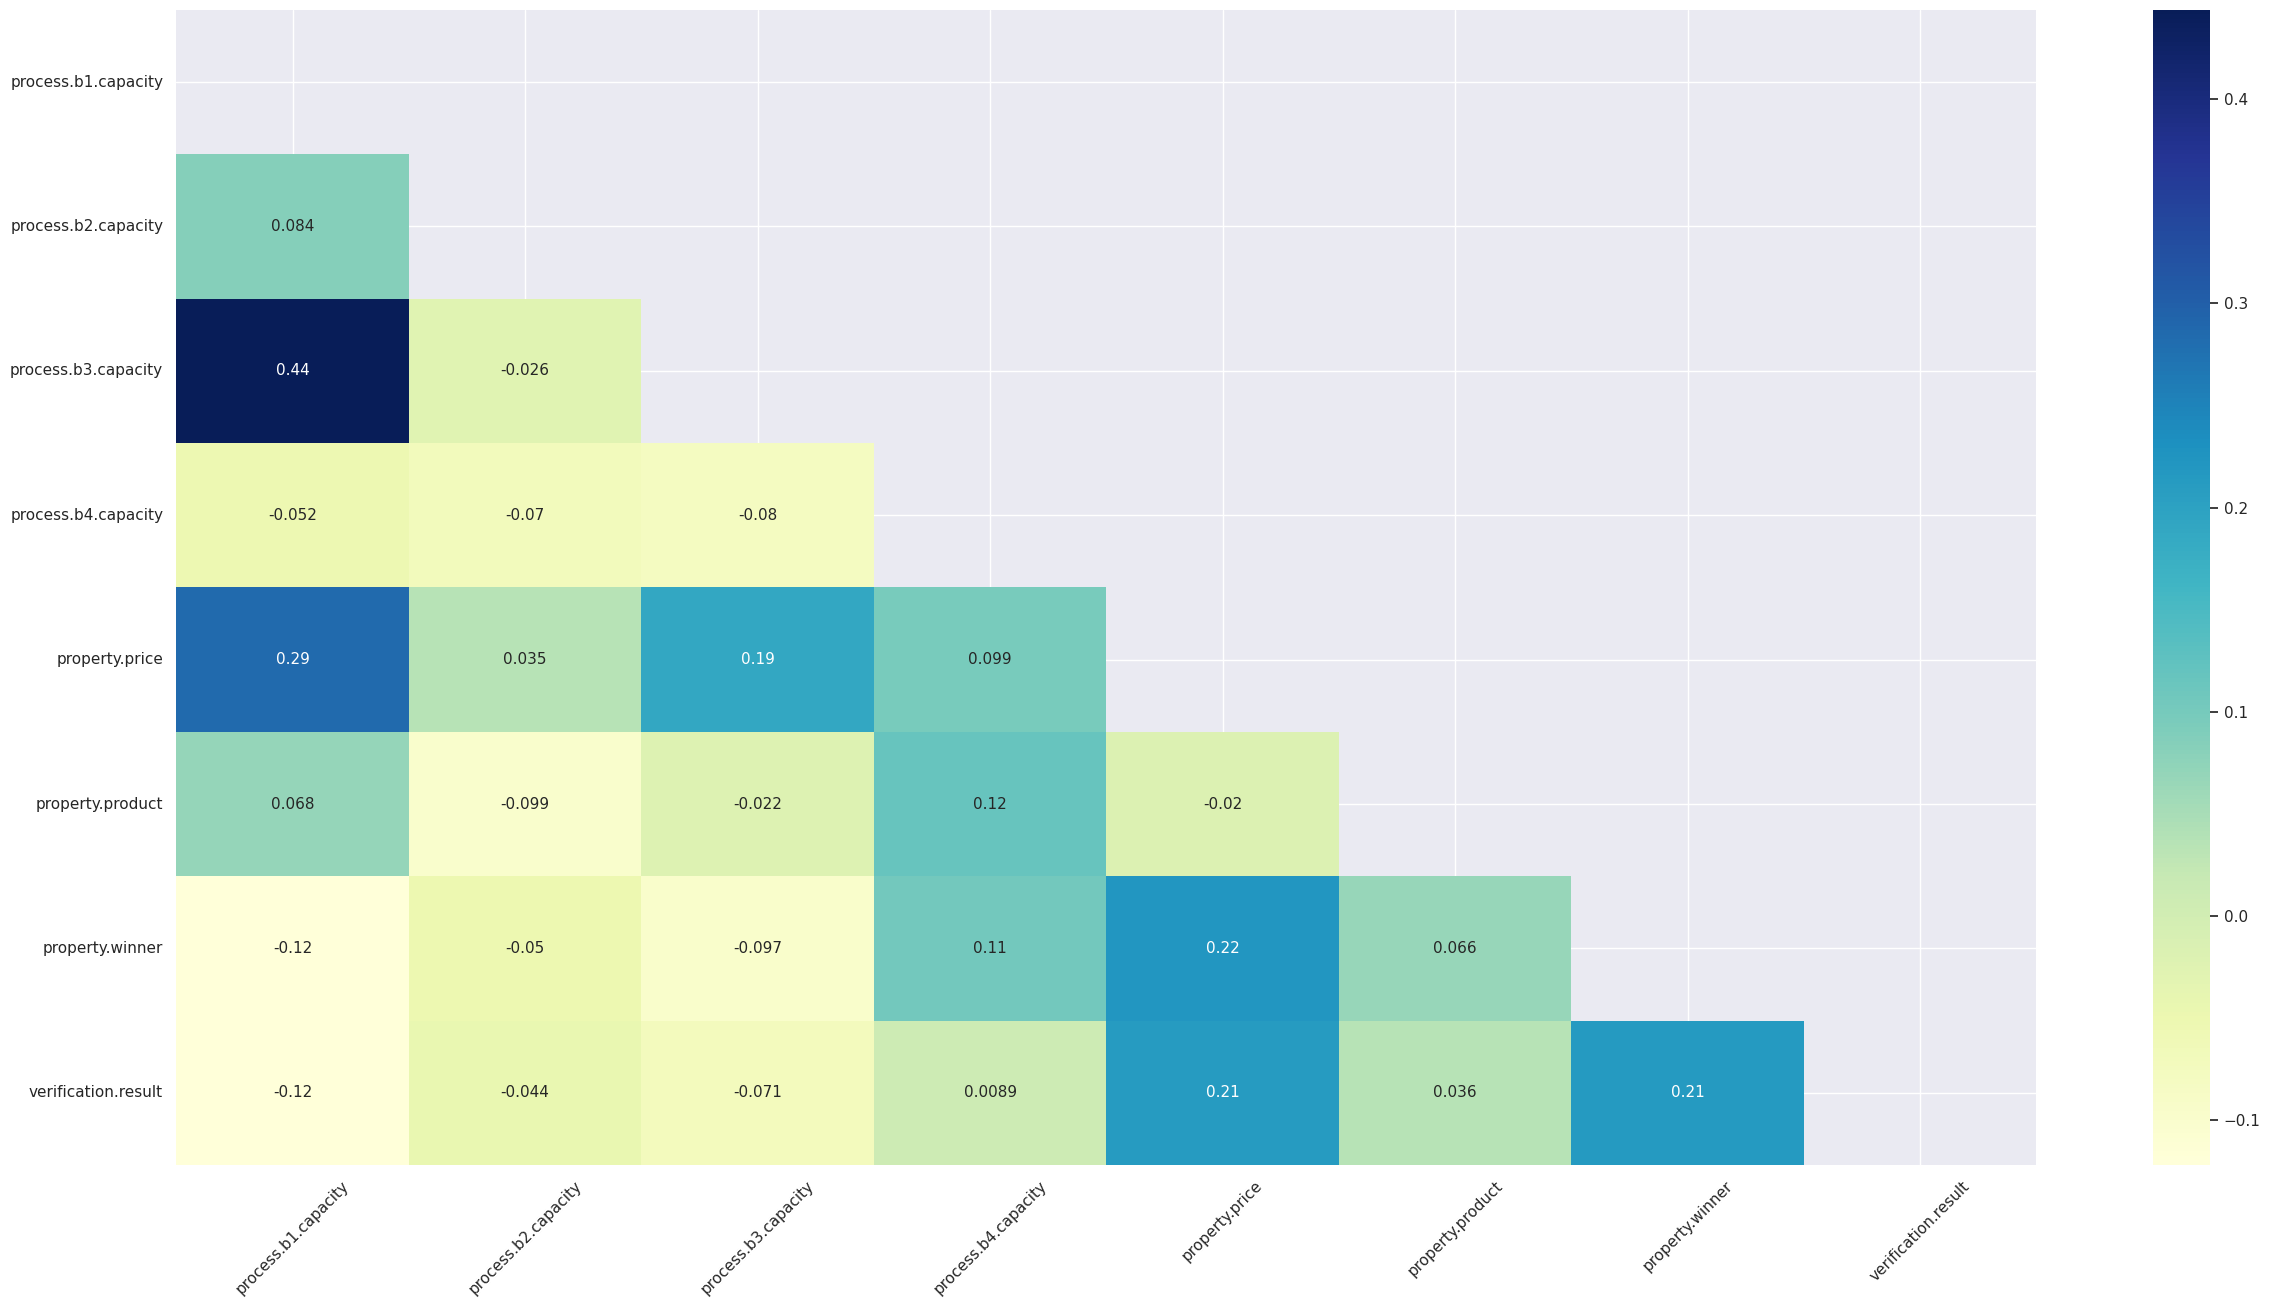

In [ ]:
df_c = df.drop(['verification.time'], axis=1) #видалення другого таргету

# Побудуємо матрицю кореляцій для першого датасету за допомогою heatmap:
corr_matrix = df_c.corr()

plt.figure(figsize=(30, 15))

# Для зручності сприйняття створимо маску для правої верхньої частини матриці:
mask = np.triu(corr_matrix)

# Створимо теплову карту з врахуванням маски:
sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True, annot_kws={"fontsize":11}, mask=mask)
plt.xticks(rotation=45)
plt.show()

Бачимо, що значної кореляції між ознаками не спостерігається. З цільовою змінною найбільше корелюють price i winner. Можна припустити, що чим більша ціна, тим більша ймовірність проходження перевірки.

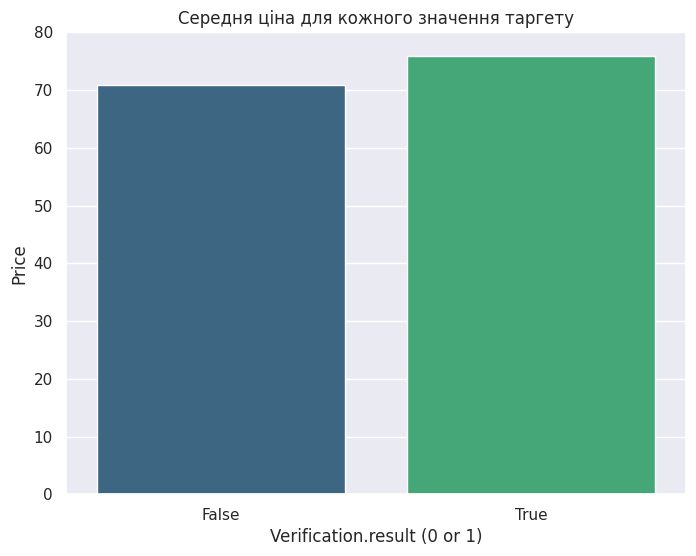

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='verification.result', y='property.price', data=df_c, palette='viridis', errorbar=None)
plt.ylim(0, 80)

# Налаштування графіка
plt.title("Середня ціна для кожного значення таргету")
plt.xlabel("Verification.result (0 or 1)")
plt.ylabel("Price")
plt.show()

In [ ]:
print('Середня ціна при позитивній верифікації:',df_c[df_c['verification.result'] == 1]['property.price'].mean())
print('Середня ціна при негативній верифікації:',df_c[df_c['verification.result'] == 0]['property.price'].mean())
print('Середня ціна:',df_c['property.price'].mean())

Середня ціна при позитивній верифікації: 75.91603053435115
Середня ціна при негативній верифікації: 70.81976417742841
Середня ціна: 71.47332354380812


Припущення підтвердилось: середня ціна при позитивній верифікації є вища, ніж середня ціна при негативній верифікації

In [ ]:
#Подивимось, які значення набуває колонка winner (переможця)
df_c['property.winner'].value_counts()

,count
property.winner,
0,1680
3,120
2,114
4,71
1,58


In [ ]:
#Оскільки значення ємності для учасників (колонки 0-3) слабко корелюють з цільовою змінною, то замінимо їх на нову ознаку - їх середнє.
df_c.insert(0, 'Average_capacity', df_c[['process.b1.capacity', 'process.b2.capacity', 'process.b3.capacity', 'process.b4.capacity']].mean(axis=1))
df_c = df_c.drop(['process.b1.capacity', 'process.b2.capacity', 'process.b3.capacity', 'process.b4.capacity'], axis=1)


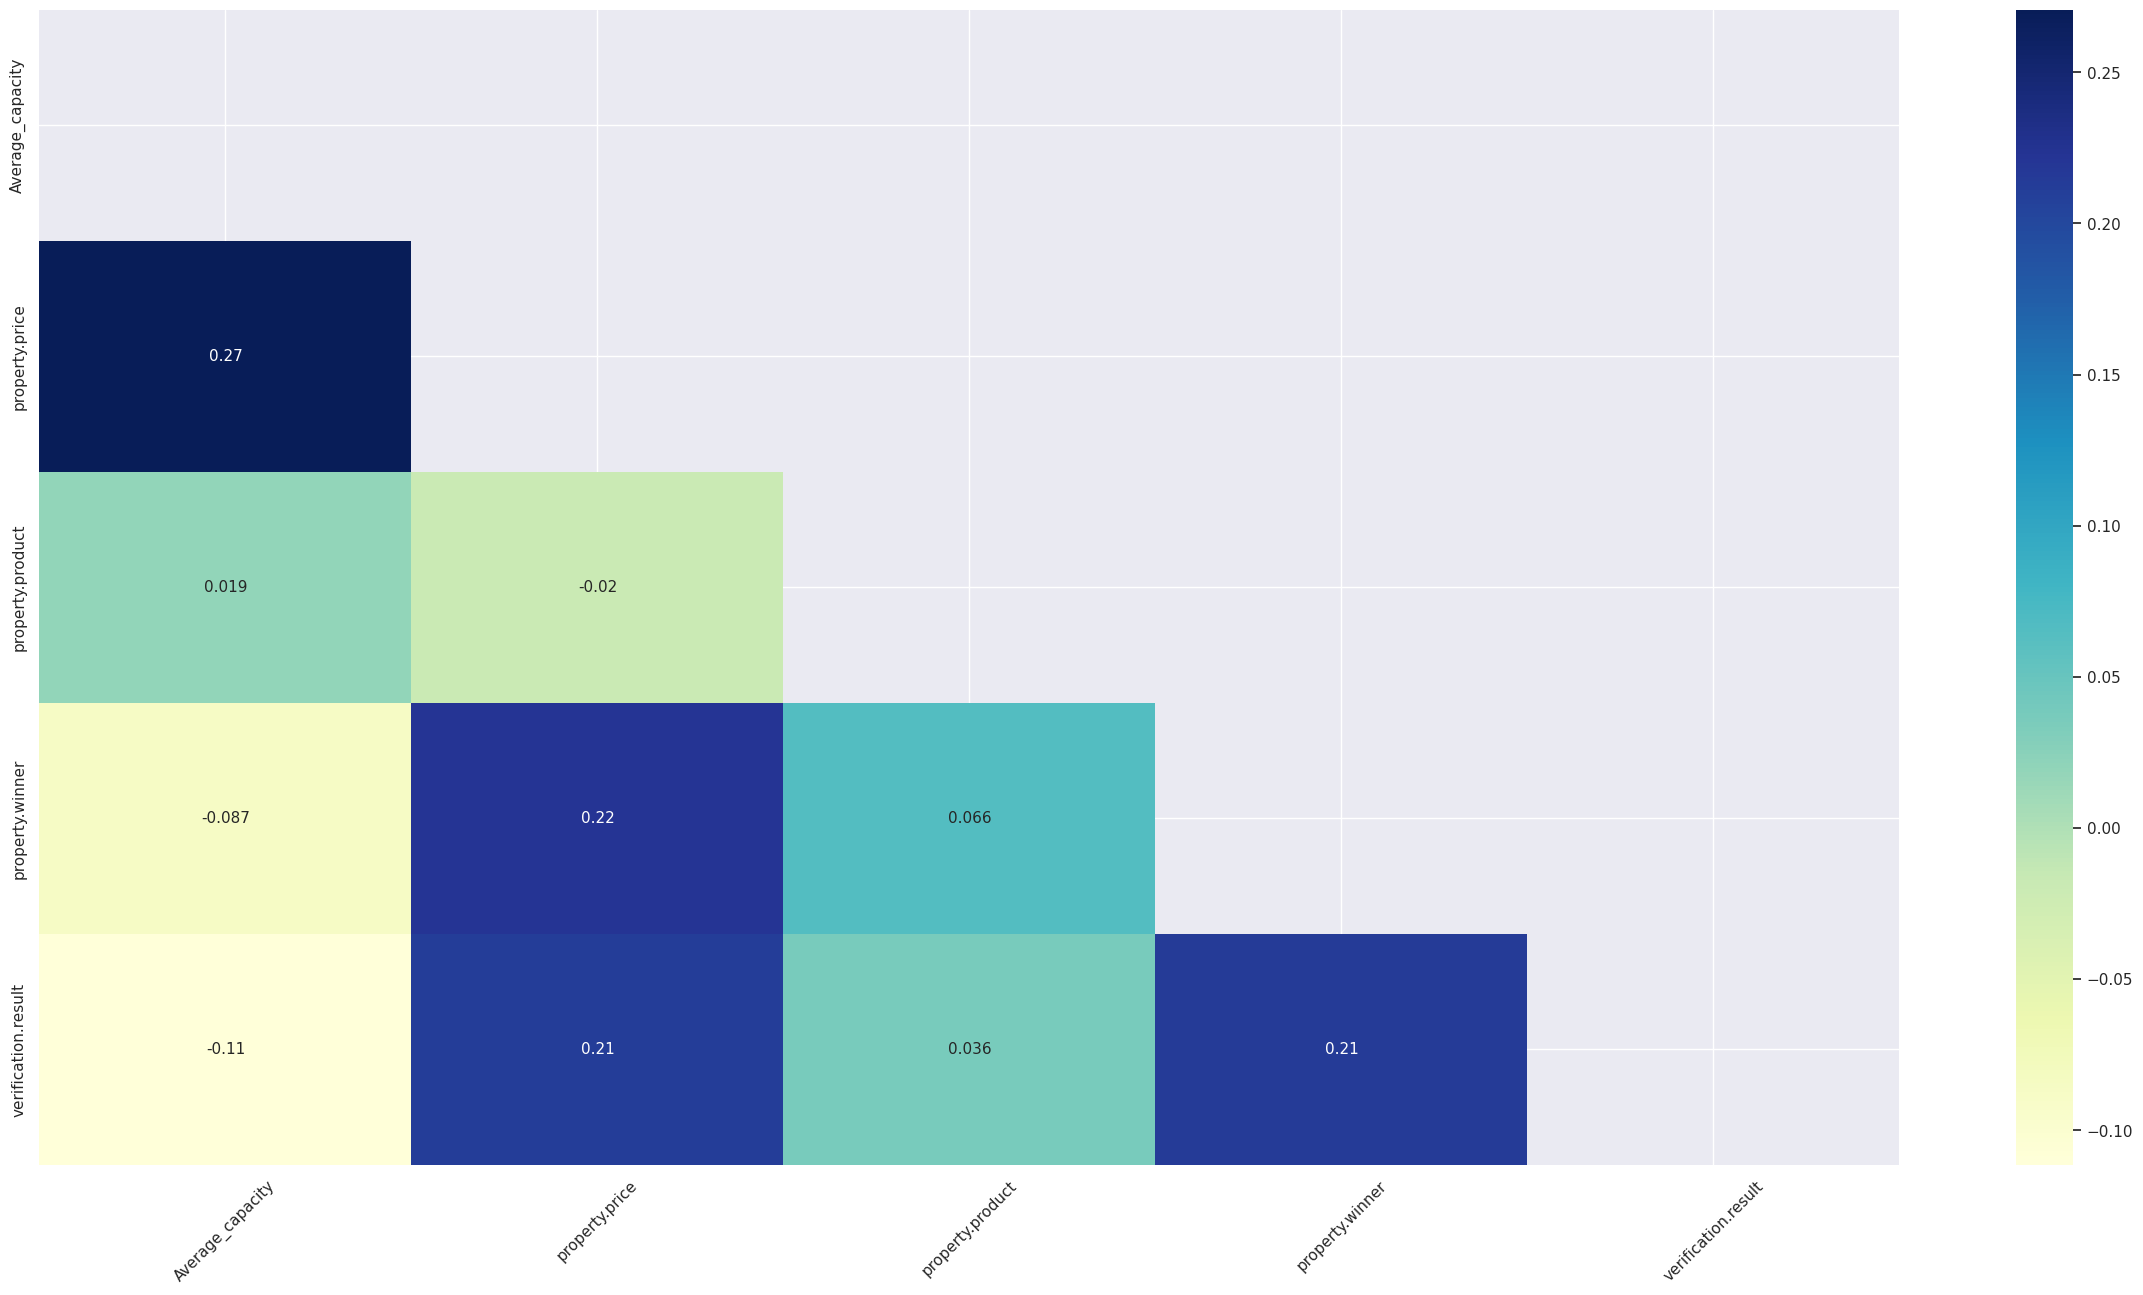

In [ ]:
# Побудуємо матрицю кореляцій для першого датасету за допомогою heatmap:
corr_matrix = df_c.corr()

plt.figure(figsize=(30, 15))

# Для зручності сприйняття створимо маску для правої верхньої частини матриці:
mask = np.triu(corr_matrix)

# Створимо теплову карту з врахуванням маски:
sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True, annot_kws={"fontsize":11}, mask=mask)
plt.xticks(rotation=45)
plt.show()

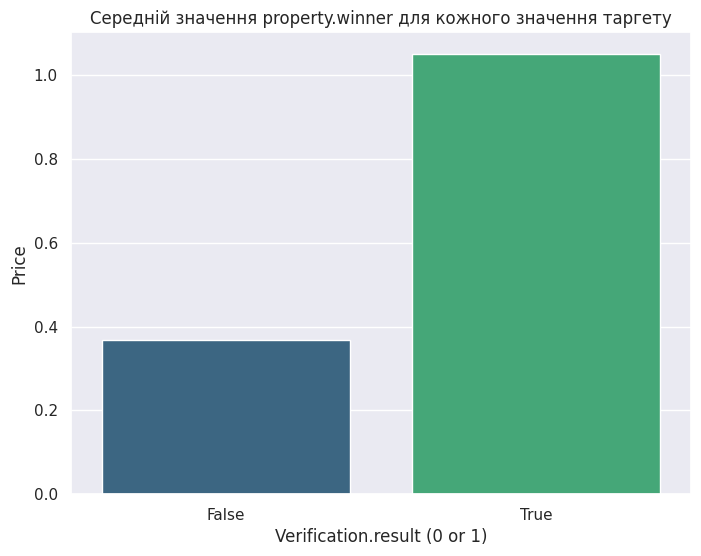

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='verification.result', y='property.winner', data=df_c, palette='viridis', errorbar=None)


# Налаштування графіка
plt.title("Середній значення property.winner для кожного значення таргету")
plt.xlabel("Verification.result (0 or 1)")
plt.ylabel("Price")
plt.show()

Побудуємо графік таргету залежно від значення в колонці учасника торгів

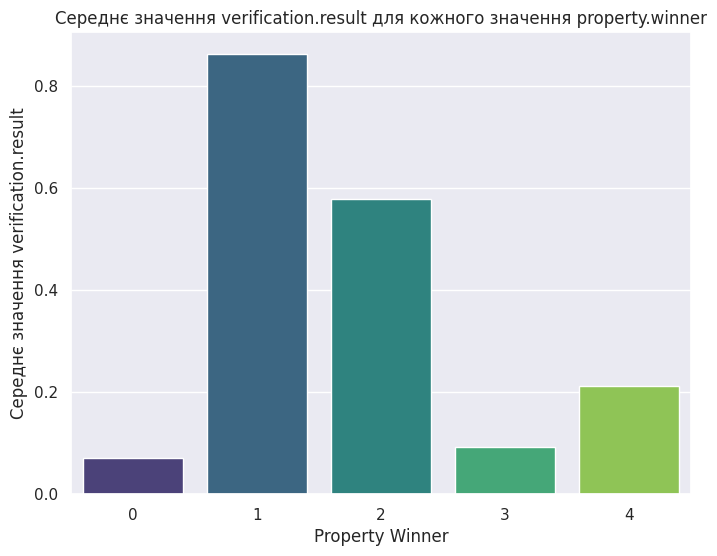

In [ ]:
# Обчислення середнього значення 'verification.result' для кожного значення 'property.winner'
df_mean = df_c.groupby('property.winner', as_index=False)['verification.result'].mean()

# Побудова графіка
plt.figure(figsize=(8, 6))
sns.barplot(x='property.winner', y='verification.result', data=df_mean, palette='viridis')

# Налаштування графіка
plt.title("Середнє значення verification.result для кожного значення property.winner")
plt.xlabel("Property Winner")
plt.ylabel("Середнє значення verification.result")
plt.show()

З двох попередніх графіків зрозуміло, що насправді кореляція за номером є від'ємна, просто випадок 0 (коли перевірено лише ціну) спотворює загальне значення кореляції за  змінною property.winner з значенням цільової змінної.
Закодуємо колонку, створивши окремі фічі.

In [ ]:
# Використаємо OneHotEncoder для кодування дискретних значень 'property.winner'

enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
df_c[['property.winner 0', 'property.winner 1', 'property.winner 2', 'property.winner 3', 'property.winner 4']] = enc.fit_transform(df_c[['property.winner']])
df_c.head()

df_c = df_c.drop(['property.winner'], axis=1) #видалення старої фічі

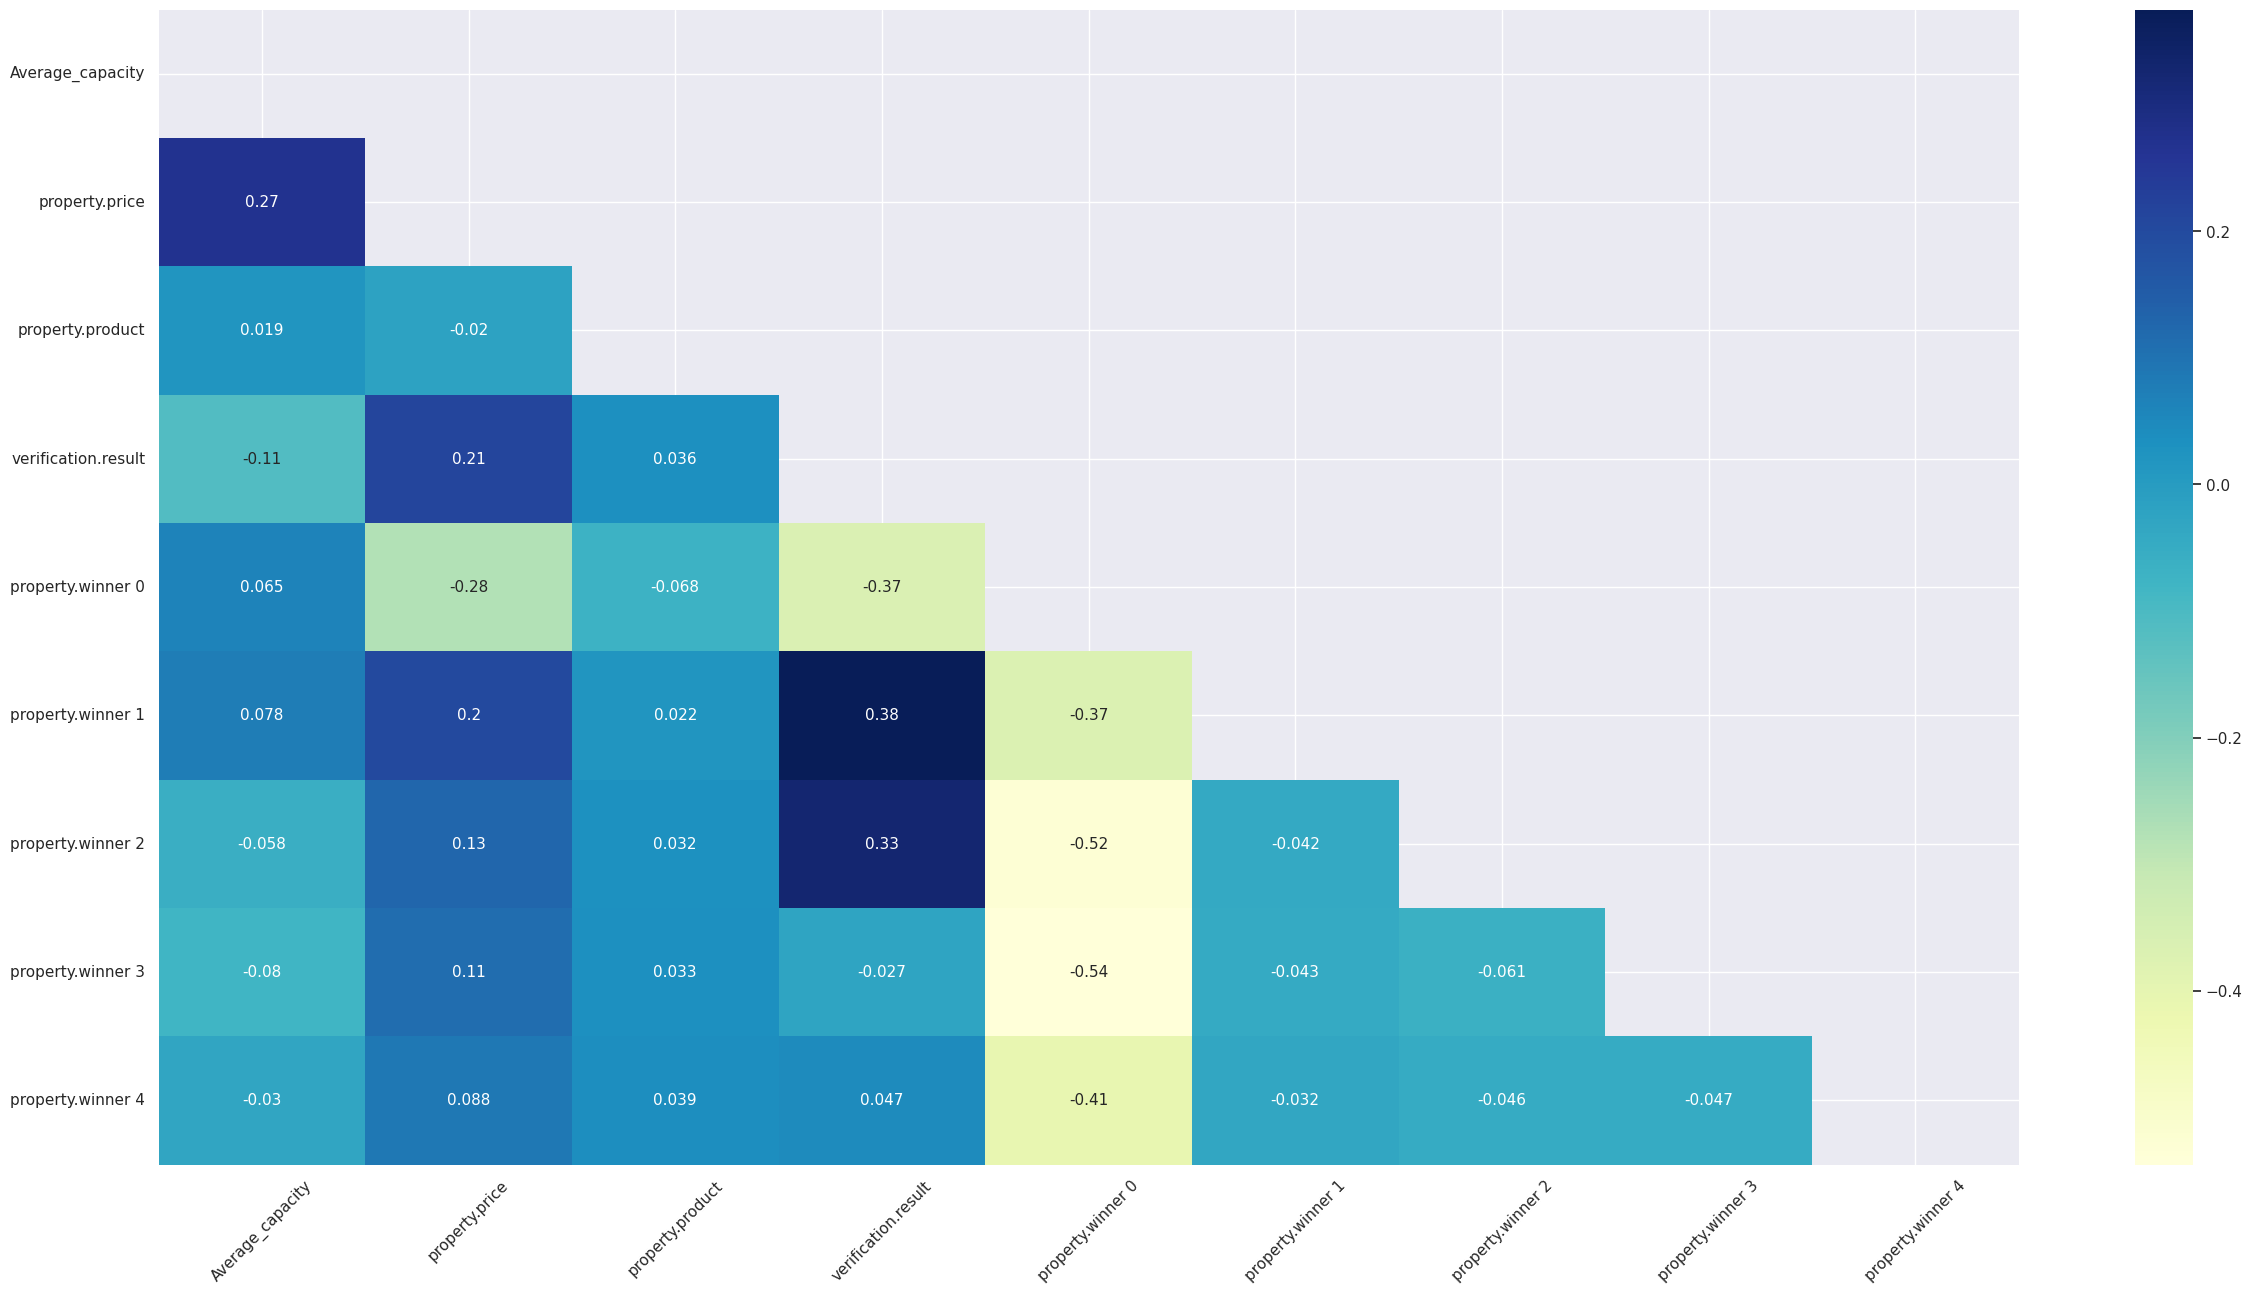

In [ ]:
# Побудуємо матрицю кореляцій для датасету за допомогою heatmap:
corr_matrix = df_c.corr()

plt.figure(figsize=(30, 15))

# Для зручності сприйняття створимо маску для правої верхньої частини матриці:
mask = np.triu(corr_matrix)

# Створимо теплову карту з врахуванням маски:
sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True, annot_kws={"fontsize":11}, mask=mask)
plt.xticks(rotation=45)
plt.show()

З графіку видно, що такими заходами вдалося суттєво підвищити кореляцію з залежною змінною.
Ймовірно, подача торгів йде у хронологічному випадку, тому учасник 1 має більше шансів, ніж нпр, останній. Це можливі також випадки, коли є тільки один учасник.

Проведемо масштабування змінних

In [ ]:
#Стандартизація значень

#Назви ознак
df_columns_scaled = list(df_c.columns)
df_columns_scaled.remove('verification.result')

#Масштабування згідно StandardScaler
sc = StandardScaler()
df_scaled = pd.DataFrame(sc.fit_transform(df_c.drop(columns='verification.result')), columns = df_columns_scaled)

X = df_scaled.copy()
y = df_c['verification.result']


# Об'єднуємо з таргетом
df_scaled = pd.concat([X, y], axis = 1)

df_scaled

,Average_capacity,property.price,property.product,property.winner 0,property.winner 1,property.winner 2,property.winner 3,property.winner 4,verification.result
0,-1.873021,-1.550103,-1.248531,0.464835,-0.170936,-0.243101,-0.249805,-0.189747,False
1,-1.873021,-1.550103,-0.694141,0.464835,-0.170936,-0.243101,-0.249805,-0.189747,False
2,-1.873021,-1.550103,0.414639,0.464835,-0.170936,-0.243101,-0.249805,-0.189747,False
3,-1.873021,-1.550103,1.523420,0.464835,-0.170936,-0.243101,-0.249805,-0.189747,False
4,-1.873021,-1.425830,-1.248531,0.464835,-0.170936,-0.243101,-0.249805,-0.189747,True
...,...,...,...,...,...,...,...,...,...
2038,1.776905,2.302374,0.969029,0.464835,-0.170936,-0.243101,-0.249805,-0.189747,True
2039,1.776905,2.302374,0.969029,-2.151302,5.850140,-0.243101,-0.249805,-0.189747,True
2040,1.776905,2.302374,0.969029,-2.151302,-0.170936,4.113521,-0.249805,-0.189747,False
2041,1.776905,2.302374,0.969029,-2.151302,-0.170936,-0.243101,4.003124,-0.189747,False


Розділяємо вибірку на тренувальну, валідаційну і тестову.



In [ ]:
# Спочатку розділяємо на тренувальну + валідаційну та тестову частини
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

# Потім розділяємо тренувальну + валідаційну на тренувальну та валідаційну частини
X_train, X_val, y_train, y_val  = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=17)  # 0.25 * 0.8 = 0.2 (20% валідаційної частини від усієї вибірки)
#В підсумку розподіл такий: train=60%, validate=20%, test=20%

#1.Bagging (дерева): RandomForest

In [ ]:
# RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=17, n_jobs=-1)
forest_clf.fit(X_train,y_train)

#Прогноз моделі
y_pred = forest_clf.predict(X_val)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
print('TP:', tp)
print('FP:', fp)
print('FN:', fn)
print('TN:', tn)
confusion_matrix(y_val, y_pred)

#Вивід значень оцінок моделі
print('Accuracy:', round(accuracy_score(y_val, y_pred) * 100, 4))
print('Precision:', round(precision_score(y_val, y_pred) *100, 4))
print('Recall:', round(recall_score(y_val, y_pred) *100, 4))
print('F1', round(f1_score(y_val, y_pred)*100, 4))

TP: 41
FP: 5
FN: 6
TN: 357
Accuracy: 97.3105
Precision: 89.1304
Recall: 87.234
F1 88.172


RandomForest показав високі характеристики, F1 = 0.88


Text(0.5, 32.249999999999986, 'Predicted Values')

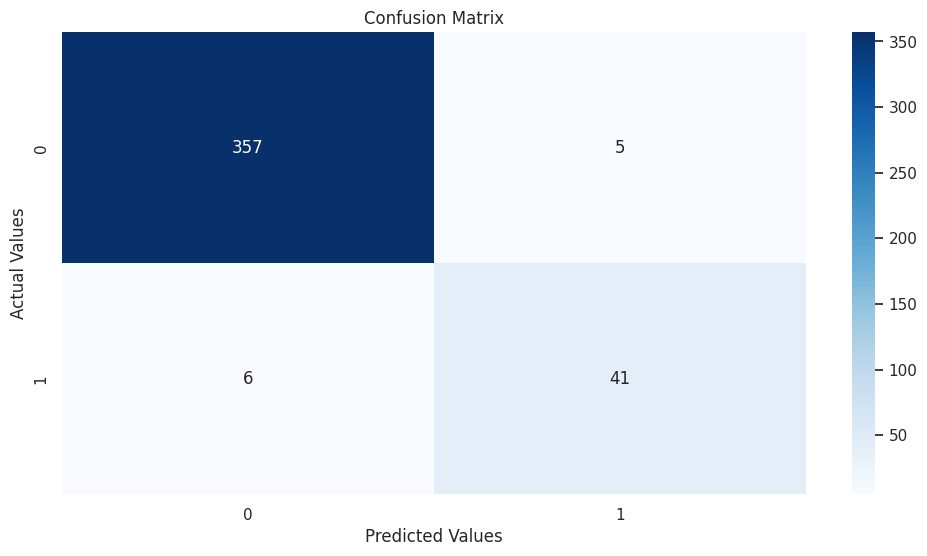

In [ ]:
#Побудуємо матрицю помилок (Confusion matrix)
cm_RF=confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12,6))
plt.title('Confusion Matrix')
sns.heatmap(cm_RF, annot=True,fmt='d', cmap='Blues')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

Бачимо, що модуль не вгадала тільки 11 значень валідаційної вибірки

Спробуємо підібрати гіперпараметри через GridSearchCV

In [ ]:
np.arange(10, 51, 10)

array([10, 20, 30, 40, 50])

In [ ]:
#GridSearchCV

param_grid = {'n_estimators': np.linspace(10, 200, 20, dtype=int),
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': [np.linspace(10, 50, 5), None],
              'max_features': [None, 'sqrt', 'log2']}

forest_clf = RandomForestClassifier(random_state=17, n_jobs=-1)

forest_clf_grid = GridSearchCV(estimator=forest_clf,
                                 param_grid=param_grid,
                                 scoring='f1',
                                 cv=5)

forest_clf_grid.fit(X_train, y_train)


print('Найкращі параметри моделі:', forest_clf_grid.best_params_)

best_model = forest_clf_grid.best_estimator_


#Прогнозування моделі
y_pred = best_model.predict(X_val)

#Вивід значень оцінок моделі
print('Accuracy:', accuracy_score(y_val, y_pred))
print('Precision:', precision_score(y_val, y_pred))
print('Recall:', recall_score(y_val, y_pred))
print('F1:', f1_score(y_val, y_pred))

Найкращі параметри моделі: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'n_estimators': 30}
Accuracy: 0.9779951100244498
Precision: 0.9130434782608695
Recall: 0.8936170212765957
F1: 0.9032258064516129


Отже, найкраща модель дерева вийшла за такими критерієм розбиття ентропією ('entropy') та 30 паралельними деревами в розрахунку.
Вдалось покращити F1 до 0.9

Text(0.5, 32.249999999999986, 'Predicted Values')

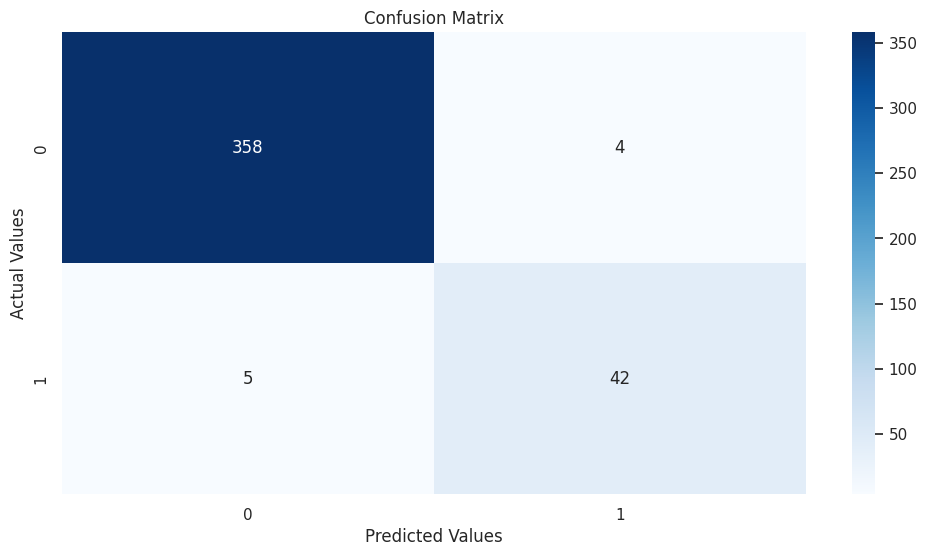

In [ ]:
#Побудуємо матрицю помилок (Confusion matrix)
cm_RF_best=confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12,6))
plt.title('Confusion Matrix')
sns.heatmap(cm_RF_best, annot=True,fmt='d', cmap='Blues')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

Кількість помилок зменшилась до 9

#2.1.Bagging (just bagging): Logistic Regression

In [ ]:
# BaggingClassifier

bagging_logreg_clf = BaggingClassifier(estimator=LogisticRegression(random_state=17), random_state=17, n_jobs=-1)
bagging_logreg_clf.fit(X_train,y_train)

#Прогноз моделі
y_pred = bagging_logreg_clf.predict(X_val)

#Вивід значень оцінок моделі
print('Accuracy:', accuracy_score(y_val, y_pred))
print('Precision:', precision_score(y_val, y_pred))
print('Recall:', recall_score(y_val, y_pred))
print('F1:', f1_score(y_val, y_pred))

Accuracy: 0.8973105134474327
Precision: 0.5925925925925926
Recall: 0.3404255319148936
F1: 0.43243243243243246


Text(0.5, 32.249999999999986, 'Predicted Values')

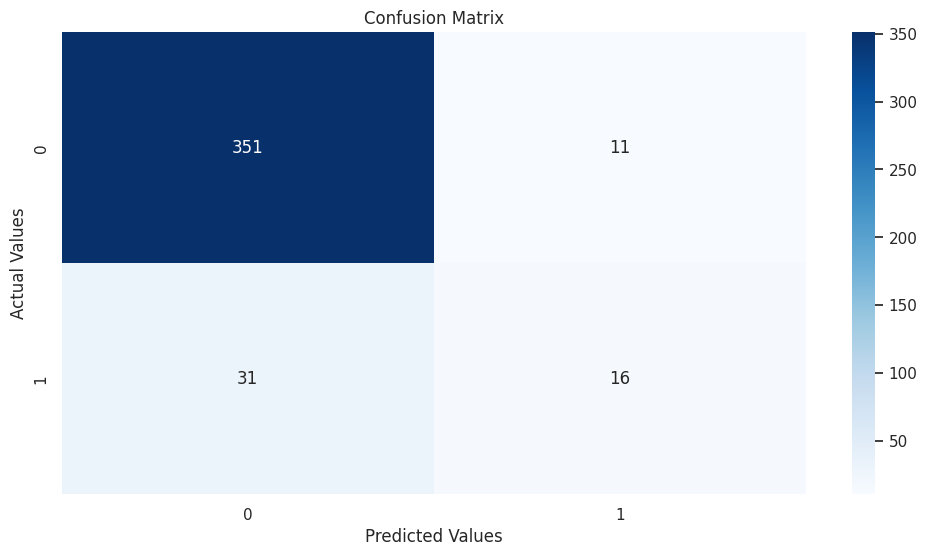

In [ ]:
#Побудуємо матрицю помилок (Confusion matrix)
cm_BG_LogReg_best=confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12,6))
plt.title('Confusion Matrix')
sns.heatmap(cm_BG_LogReg_best, annot=True,fmt='d', cmap='Blues')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

Бачимо, що логістична регресія за своїми базовими параметрами не підходить для цього датасету (залежність тут не є лінійною). Модель має проблеми з виявленням позитивних значень таргету: з 47 значень виявлено лише 16, 31 не виявлено, відповідно, Recall низьке.

Подивимось bagging для поліноміальної моделі логістичної регресії для поліномів різних степенів

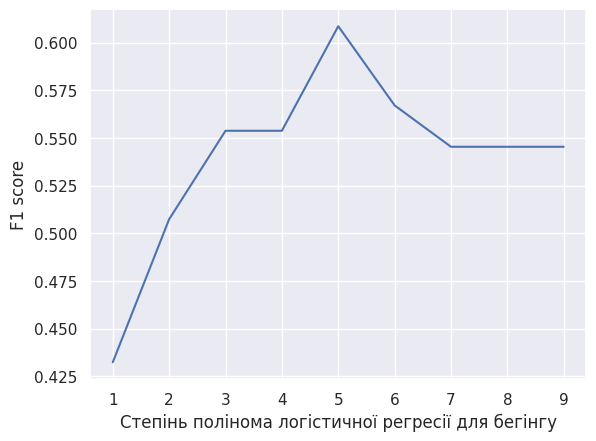

In [ ]:
# Створення поліноміальної моделі логістичної регресії для bagging
f1_scores = []
degree_n = []

#Цикл по степені полінома для моделі
for degree in range(1,10):

  poly_clf = Pipeline([
      ('poly', PolynomialFeatures(degree=degree)),  # Генерація поліноміальних ознак
      ('logreg', LogisticRegression(random_state=17))             # Логістична регресія
  ])


  # BaggingClassifier

  bagging_logreg_poly_clf = BaggingClassifier(n_estimators=10, estimator=poly_clf, random_state=17, n_jobs=-1)
  bagging_logreg_poly_clf.fit(X_train,y_train)

  #Прогноз моделі
  y_pred = bagging_logreg_poly_clf.predict(X_val)
  #Прогноз моделі
  y_pred = bagging_logreg_poly_clf.predict(X_val)
  # Навчання моделі
  bagging_logreg_poly_clf.fit(X_train, y_train)

  # Прогнозування
  y_pred = bagging_logreg_poly_clf.predict(X_val)

  f1_scores.append(f1_score(y_val, y_pred))
  degree_n.append(degree)

  '''
  #Вивід значень оцінок моделі
  print('Accuracy:', accuracy_score(y_val, y_pred), 'degree', degree)
  print('Precision:', precision_score(y_val, y_pred), 'degree', degree)
  print('Recall:', recall_score(y_val, y_pred), 'degree', degree)
  print('F1:', f1_score(y_val, y_pred), 'degree', degree)
  '''

plt.plot(degree_n, f1_scores)
plt.xlabel('Степінь полінома логістичної регресії для бегінгу')
plt.ylabel('F1 score')
plt.show()

З графіка видно, що для бегінгу з логістичною регресією найкращим рішенням є використання полінома 6 степеня, надалі вже характеристики моделі падають. Пояснення в тому, що для бегінгу допускається певна перенавченість моделі, але до певної міри. Але загалом максимальний показник f1 біля 0,6 є відносно малим, відповідно можна стверджувати, що кращою моделлю для бегінгу є використання дерев (лісу), ніж логістичної регресії (збільшення кількості паралельних моделей теж не вплинуло на ситуацію).

#2.2.Bagging (just bagging): kNN

In [ ]:
# BaggingClassifier for kNN

bagging_knn_clf = BaggingClassifier(estimator=KNeighborsClassifier(),n_estimators=100, random_state=17, n_jobs=-1)
bagging_knn_clf.fit(X_train,y_train)

#Прогноз моделі
y_pred = bagging_knn_clf.predict(X_val)

#Вивід значень оцінок моделі
print('Accuracy:', accuracy_score(y_val, y_pred))
print('Precision:', precision_score(y_val, y_pred))
print('Recall:', recall_score(y_val, y_pred))
print('F1:', f1_score(y_val, y_pred))

Accuracy: 0.9388753056234719
Precision: 0.9230769230769231
Recall: 0.5106382978723404
F1: 0.6575342465753424


Text(0.5, 32.249999999999986, 'Predicted Values')

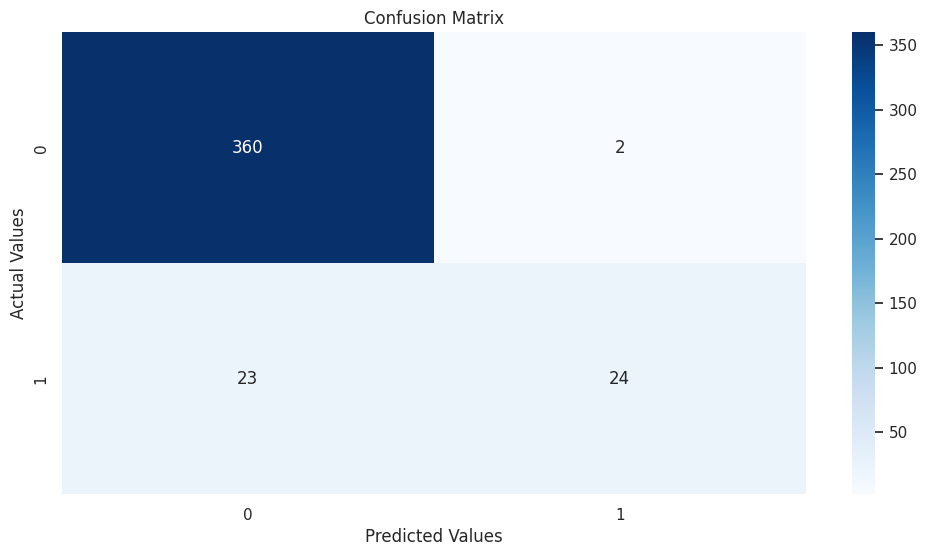

In [ ]:
#Побудуємо матрицю помилок (Confusion matrix)
cm_BG_knn=confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12,6))
plt.title('Confusion Matrix')
sns.heatmap(cm_BG_knn, annot=True,fmt='d', cmap='Blues')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

Модель бегінгу з використанням kNN має свої особливості: вона найкраща зі всіх попередніх моделей в частині точності (Precision), але разом з тим має проблеми в параметрі Recall, виявивши тільки 24 спрацювання таргету з 47. Тому й показник f1 менший, ніж у RandomForest.

Спробуємо підібрати параметри по кількості сусідів

In [ ]:
#GridSearchCV


# Базовий оцінювач (KNeighborsClassifier)
knn = KNeighborsClassifier()

# BaggingClassifier з базовим оцінювачем
bagging_knn = BaggingClassifier(estimator=knn, random_state=17)

# Сітка параметрів для GridSearchCV
param_grid = {
    'estimator__n_neighbors': np.arange(5, 41, 5),  # Кількість сусідів для kNN
    'n_estimators': [10, 50, 100],             # Кількість базових моделей в Bagging
    'max_samples': [0.5, 0.7, 1.0],           # Частка вибірки для кожного класифікатора
    'max_features': [0.5, 0.7, 1.0]           # Частка ознак для кожного класифікатора
}

# Налаштування GridSearchCV
bag_knn_grid = GridSearchCV(
    estimator=bagging_knn,
    param_grid=param_grid,
    scoring='f1',
    cv=5,            # Кількість фолдів для крос-валідації
    n_jobs=-1        # Використання всіх доступних ядер процесора
)

# Навчання GridSearchCV
bag_knn_grid.fit(X_train, y_train)

# Найкращі параметри
print('Найкращі параметри моделі:', bag_knn_grid.best_params_)

# Оцінка на тестовій вибірці
best_model = bag_knn_grid.best_estimator_
y_pred = best_model.predict(X_val)

#Вивід значень оцінок моделі
print('Accuracy:', accuracy_score(y_val, y_pred))
print('Precision:', precision_score(y_val, y_pred))
print('Recall:', recall_score(y_val, y_pred))
print('F1:', f1_score(y_val, y_pred))




Найкращі параметри моделі: {'estimator__n_neighbors': 5, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10}
Accuracy: 0.9290953545232273
Precision: 0.8
Recall: 0.5106382978723404
F1: 0.6233766233766234


Text(0.5, 32.249999999999986, 'Predicted Values')

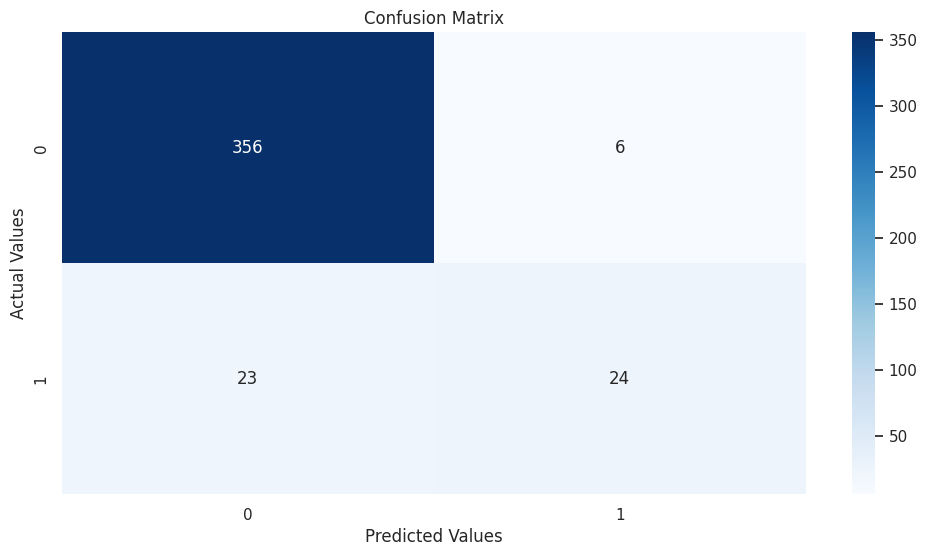

In [ ]:
#Побудуємо матрицю помилок (Confusion matrix)
cm_BG_best_knn=confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12,6))
plt.title('Confusion Matrix')
sns.heatmap(cm_BG_best_knn, annot=True,fmt='d', cmap='Blues')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

Як бачимо, що підбір параметрів не дав ефекту в частині збільшення повноти.
Тому, підсумовуючи, в загальному для бегінгу найкраще використовувати модель з деревами, якщо ж важлива саме точність (Precision), то найкраще рішення дає бегінг з використанням методу найближчих сусідів.

# 3.1.Boosting: GradientBoostingClassifier


In [ ]:
# GradientBoostingClassifier (оскільки моделі мають бути недонавченими, то ставимо низьке значення max_depth=3)

gb_clf = GradientBoostingClassifier(max_depth=3, random_state=17)
gb_clf.fit(X_train,y_train)

#Прогноз моделі
y_pred = gb_clf.predict(X_val)

#Вивід значень оцінок моделі
print('Accuracy:', accuracy_score(y_val, y_pred))
print('Precision:', precision_score(y_val, y_pred))
print('Recall:', recall_score(y_val, y_pred))
print('F1:', f1_score(y_val, y_pred))

Accuracy: 0.9706601466992665
Precision: 0.926829268292683
Recall: 0.8085106382978723
F1: 0.8636363636363636


Text(0.5, 32.249999999999986, 'Predicted Values')

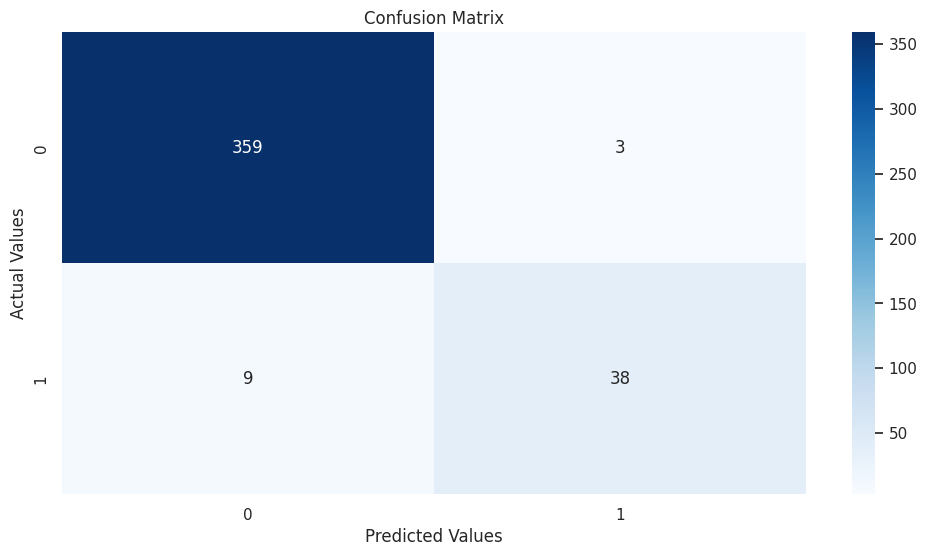

In [ ]:
#Побудуємо матрицю помилок (Confusion matrix)
cm_gb_clf=confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12,6))
plt.title('Confusion Matrix')
sns.heatmap(cm_gb_clf, annot=True,fmt='d', cmap='Blues')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

Модель показала добрі результати: F1 > 0.86

# 3.2.Boosting:AdaBoostClassifier

In [ ]:
# AdaBoostClassifier

ada_clf = AdaBoostClassifier(random_state=17)
ada_clf.fit(X_train,y_train)

#Прогноз моделі
y_pred = ada_clf.predict(X_val)

#Вивід значень оцінок моделі
print('Accuracy:', accuracy_score(y_val, y_pred))
print('Precision:', precision_score(y_val, y_pred))
print('Recall:', recall_score(y_val, y_pred))
print('F1:', f1_score(y_val, y_pred))

Accuracy: 0.9119804400977995
Precision: 0.6170212765957447
Recall: 0.6170212765957447
F1: 0.6170212765957447


Text(0.5, 32.249999999999986, 'Predicted Values')

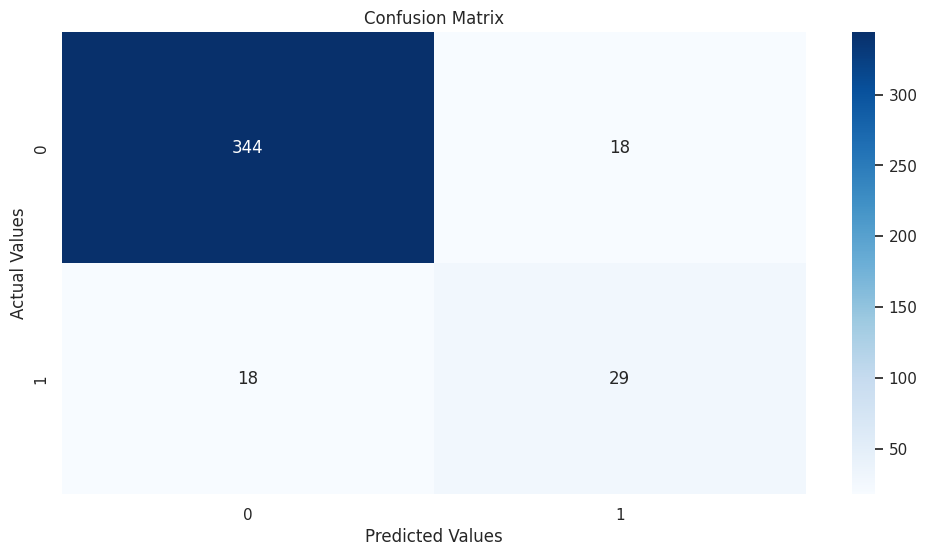

In [ ]:
#Побудуємо матрицю помилок (Confusion matrix)
cm_ada_clf=confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12,6))
plt.title('Confusion Matrix')
sns.heatmap(cm_ada_clf, annot=True,fmt='d', cmap='Blues')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

AdaBoostClassifier у порівняні з GradientBoostingClassifier дає гірші результати, причому як для Precision, так і для Recall

# 3.3.Boosting: XGBoost


In [ ]:
# XGBoost

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=17)
xgb_model.fit(X_train,y_train)

#Прогноз моделі
y_pred = xgb_model.predict(X_val)

#Вивід значень оцінок моделі
print('Accuracy:', accuracy_score(y_val, y_pred))
print('Precision:', precision_score(y_val, y_pred))
print('Recall:', recall_score(y_val, y_pred))
print('F1:', f1_score(y_val, y_pred))

Accuracy: 0.980440097799511
Precision: 0.9148936170212766
Recall: 0.9148936170212766
F1: 0.9148936170212766


Text(0.5, 32.249999999999986, 'Predicted Values')

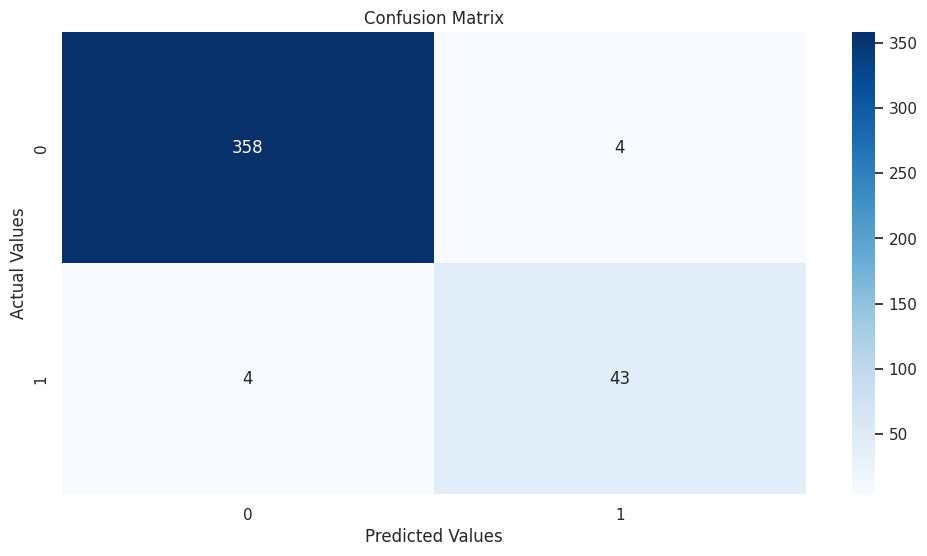

In [ ]:
#Побудуємо матрицю помилок (Confusion matrix)
cm_ada_clf=confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12,6))
plt.title('Confusion Matrix')
sns.heatmap(cm_ada_clf, annot=True,fmt='d', cmap='Blues')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

Модель XGBoost показала дуже добрий результат: F1 >0.91

Подивимось ще на модель LGBMClassifier

#3.4 Boosting: LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier
# lightgbm.LGBMClassifier

lightgbm_model = LGBMClassifier(objective="binary", random_state=17)
lightgbm_model.fit(X_train,y_train)

#Прогноз моделі
y_pred = lightgbm_model.predict(X_val)

#Вивід значень оцінок моделі
print('Accuracy:', accuracy_score(y_val, y_pred))
print('Precision:', precision_score(y_val, y_pred))
print('Recall:', recall_score(y_val, y_pred))
print('F1:', f1_score(y_val, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 161, number of negative: 1064
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62
[LightGBM] [Info] Number of data points in the train set: 1225, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.131429 -> initscore=-1.888386
[LightGBM] [Info] Start training from score -1.888386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

Text(0.5, 32.249999999999986, 'Predicted Values')

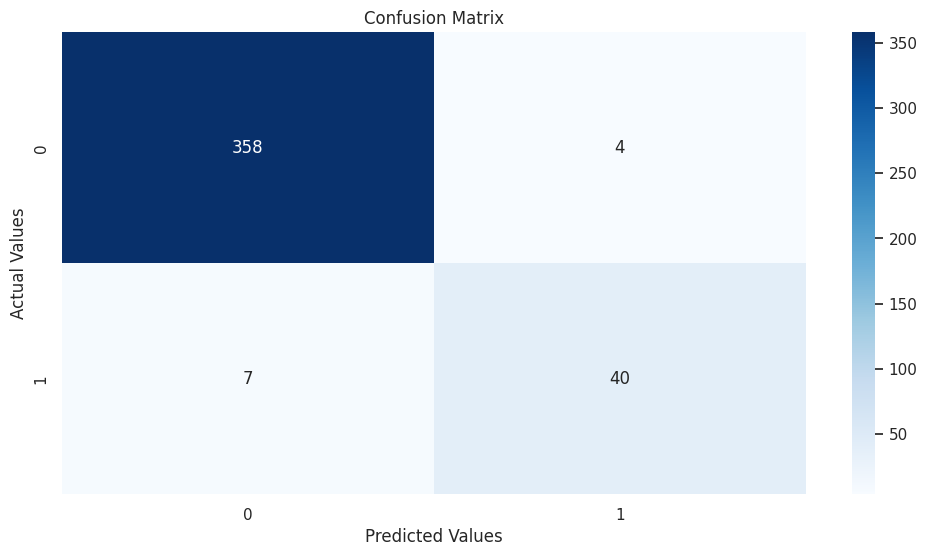

In [ ]:
#Побудуємо матрицю помилок (Confusion matrix)
cm_ada_clf=confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12,6))
plt.title('Confusion Matrix')
sns.heatmap(cm_ada_clf, annot=True,fmt='d', cmap='Blues')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

Висновок по етапу бустинг: найкращою моделлю по середніх показниках виявилась XGBoost, в частині Precision також дуже добрі показники у LGBMClassifier та GradientBoostingClassifier

Спробуємо підібрати параметри моделі

In [ ]:
#GridSearchCV

# Сітка параметрів
param_grid = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]}

xgb_clf = xgb.XGBClassifier(objective="binary:logistic", random_state=17)


# Налаштування GridSearchCV
xgb_clf_grid = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)


xgb_clf_grid.fit(X_train, y_train)


print('Найкращі параметри моделі:', xgb_clf_grid.best_params_)

best_model = xgb_clf_grid.best_estimator_


#Прогнозування моделі
y_pred = best_model.predict(X_val)

#Вивід значень оцінок моделі
print('Accuracy:', accuracy_score(y_val, y_pred))
print('Precision:', precision_score(y_val, y_pred))
print('Recall:', recall_score(y_val, y_pred))
print('F1:', f1_score(y_val, y_pred))

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Найкращі параметри моделі: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
Accuracy: 0.9779951100244498
Precision: 0.9130434782608695
Recall: 0.8936170212765957
F1: 0.9032258064516129


Text(0.5, 32.249999999999986, 'Predicted Values')

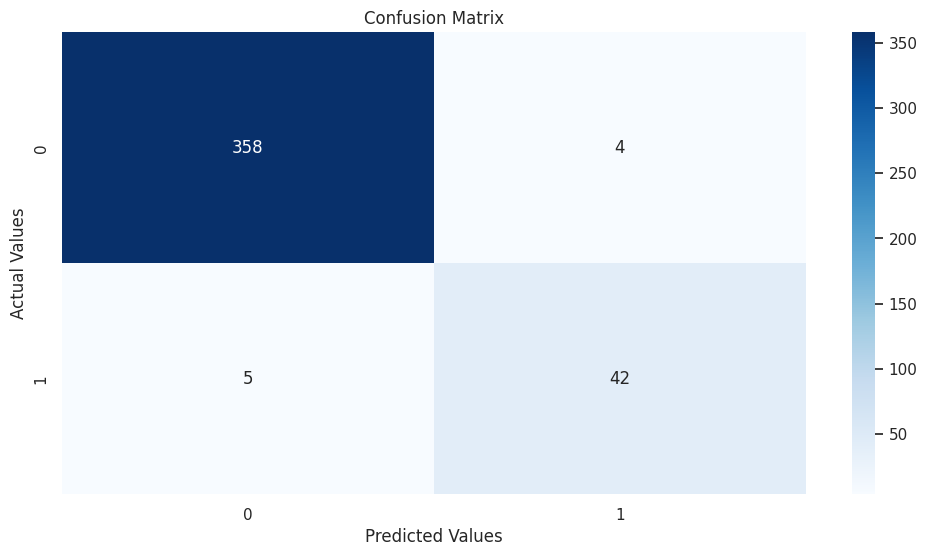

In [ ]:
#Побудуємо матрицю помилок (Confusion matrix)
cm_xgb_clf_grid=confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12,6))
plt.title('Confusion Matrix')
sns.heatmap(cm_xgb_clf_grid, annot=True,fmt='d', cmap='Blues')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

Через GridSearchCV не вдалося покращити модель

#4. Stacking

In [ ]:
from sklearn.svm import LinearSVC

estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=17)),
    ('svr', LinearSVC(random_state=17)),
    ('knn', KNeighborsClassifier()),
    ]
stack_clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(random_state=17)
)

stack_clf.fit(X_train, y_train)

#Прогноз моделі
y_pred = stack_clf.predict(X_val)

#Вивід значень оцінок моделі
print('Accuracy:', accuracy_score(y_val, y_pred))
print('Precision:', precision_score(y_val, y_pred))
print('Recall:', recall_score(y_val, y_pred))
print('F1:', f1_score(y_val, y_pred))

Accuracy: 0.9682151589242054
Precision: 0.925
Recall: 0.7872340425531915
F1: 0.8505747126436781


Text(0.5, 32.249999999999986, 'Predicted Values')

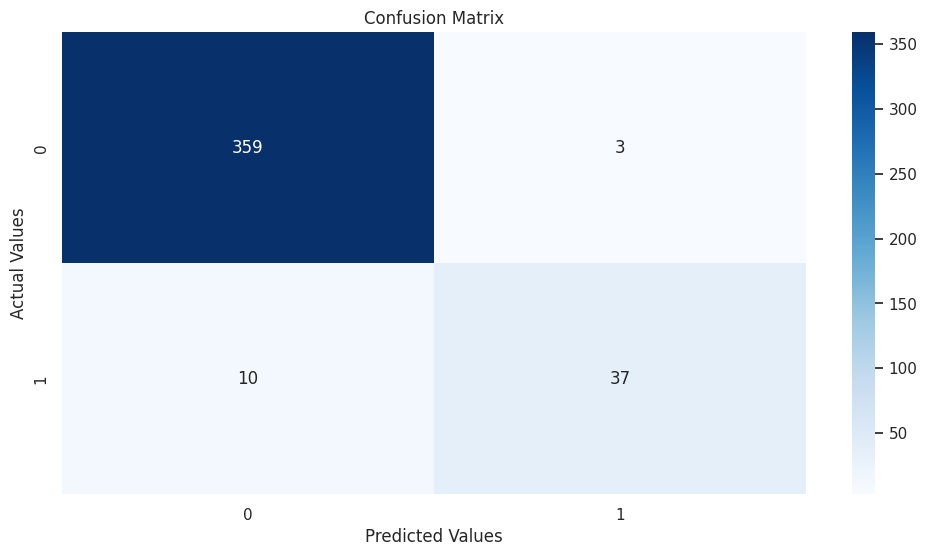

In [ ]:
#Побудуємо матрицю помилок (Confusion matrix)
cm_stack_clf=confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12,6))
plt.title('Confusion Matrix')
sns.heatmap(cm_stack_clf, annot=True,fmt='d', cmap='Blues')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

Модель дуже добре спрацювала на Precision (0.97), але є нижчий показник Recall, що й вплинуло на середнє f1 (0.85)

In [ ]:

# Спробуємо підібрати параметри за GridSearchCV
estimators = [
    ('rf', RandomForestClassifier(random_state=17)),
    ('svr', LinearSVC(random_state=17)),
    ('knn', KNeighborsClassifier())
]

# StackingClassifier
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=17)
)

# Сітка параметрів
param_grid = {
    'rf__n_estimators': [10, 50, 100],
    'rf__max_depth': [3, 5, 10],
    'svr__C': [0.01, 0.1, 1],
    'knn__n_neighbors': [3, 5, 7],
    'final_estimator__C': [0.01, 0.1, 1]
}

# GridSearchCV
stacking_grid = GridSearchCV(
    estimator=stack_clf,
    param_grid=param_grid,
    cv=5,              # Крос-валідація
    scoring='f1',
    n_jobs=-1          # Паралельна обробка
)

# Навчання GridSearchCV
stacking_grid.fit(X_train, y_train)

# Найкращі параметри
print("Найкращі параметри:", stacking_grid.best_params_)
print("Найкращий результат:", stacking_grid.best_score_)

#Прогноз моделі
y_pred = stacking_grid.predict(X_val)

#Вивід значень оцінок моделі
print('Accuracy:', accuracy_score(y_val, y_pred))
print('Precision:', precision_score(y_val, y_pred))
print('Recall:', recall_score(y_val, y_pred))
print('F1:', f1_score(y_val, y_pred))

Найкращі параметри: {'final_estimator__C': 1, 'knn__n_neighbors': 7, 'rf__max_depth': 10, 'rf__n_estimators': 50, 'svr__C': 0.01}
Найкращий результат: 0.8721640076133472
Accuracy: 0.9706601466992665
Precision: 0.9069767441860465
Recall: 0.8297872340425532
F1: 0.8666666666666667


Text(0.5, 32.249999999999986, 'Predicted Values')

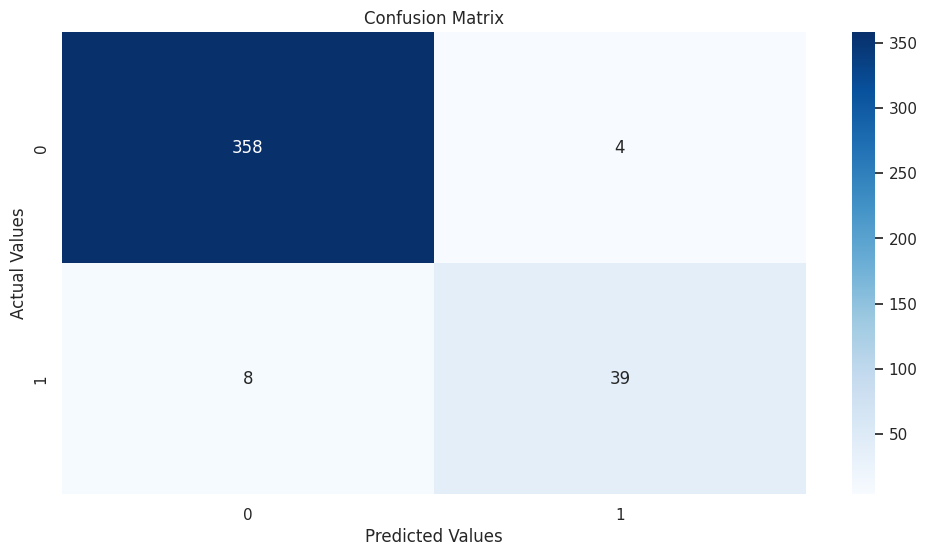

In [ ]:
#Побудуємо матрицю помилок (Confusion matrix)
cm_stacking_grid=confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12,6))
plt.title('Confusion Matrix')
sns.heatmap(cm_stacking_grid, annot=True,fmt='d', cmap='Blues')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

Після підбору гіперпараметрів модель трішки покрашилася

#Останній етап: порівняння кращих моделей на тестовій вибірці

Порівнюватимемо:
1. Random Forest з параметрами {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'n_estimators': 30}
2. XGBClassifier(objective="binary:logistic", random_state=17)
3. Stacking з estimators = {'final_estimator__C': 1, 'knn__n_neighbors': 7, 'rf__max_depth': 10, 'rf__n_estimators': 50, 'svr__C': 0.01}

In [ ]:
#I. Random Forest
# RandomForestClassifier

forest_clf_best = RandomForestClassifier(criterion = 'entropy', max_features = None, n_estimators = 30, random_state=17, n_jobs=-1)
forest_clf_best.fit(X_train,y_train)

#Прогноз моделі
y_pred = forest_clf_best.predict(X_test)


#Вивід значень оцінок моделі
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred))

Accuracy: 0.9828850855745721
Precision: 0.9272727272727272
Recall: 0.9444444444444444
F1: 0.9357798165137615


Text(0.5, 32.249999999999986, 'Predicted Values')

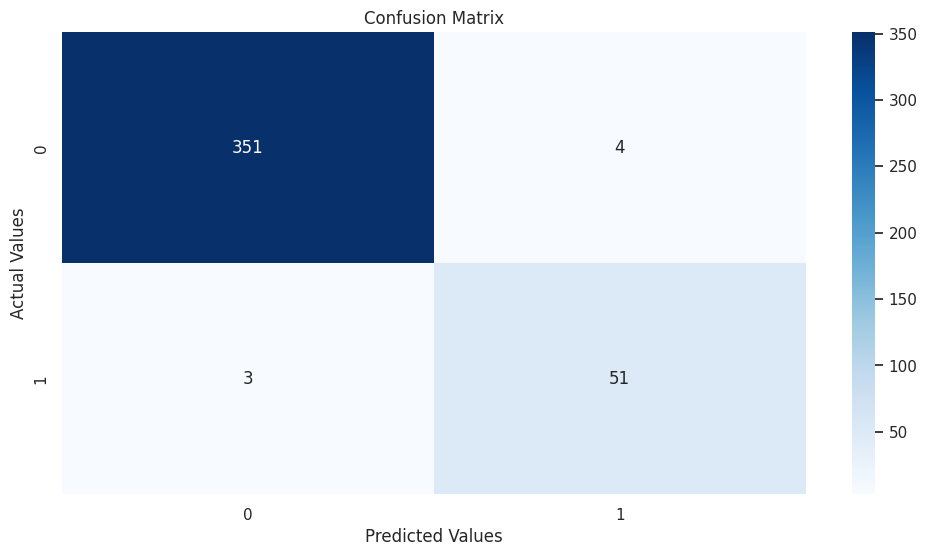

In [ ]:
#Побудуємо матрицю помилок (Confusion matrix)
cm_forest_clf_best=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,6))
plt.title('Confusion Matrix')
sns.heatmap(cm_forest_clf_best, annot=True,fmt='d', cmap='Blues')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

In [ ]:
#II. XGBoost

# XGBoost

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=17)
xgb_model.fit(X_train,y_train)

#Прогноз моделі
y_pred = xgb_model.predict(X_test)

#Вивід значень оцінок моделі
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred))

Accuracy: 0.980440097799511
Precision: 0.9107142857142857
Recall: 0.9444444444444444
F1: 0.9272727272727272


Text(0.5, 32.249999999999986, 'Predicted Values')

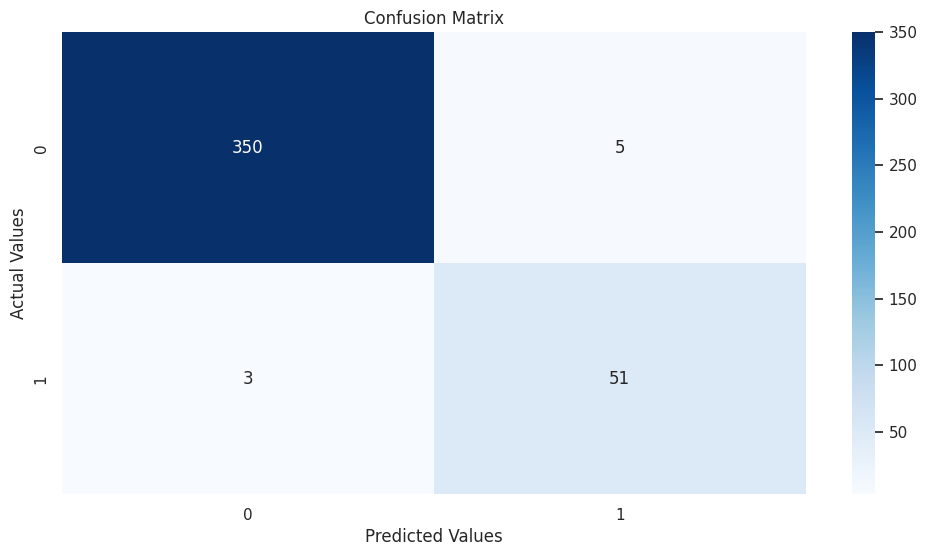

In [ ]:
#Побудуємо матрицю помилок (Confusion matrix)
cm_xgb_model=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,6))
plt.title('Confusion Matrix')
sns.heatmap(cm_xgb_model, annot=True,fmt='d', cmap='Blues')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

In [ ]:
#III Stacking

estimators = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=17, max_depth = 10)),
    ('svr', LinearSVC(random_state=17, C=0.01)),
    ('knn', KNeighborsClassifier(n_neighbors = 7)),
    ]
stack_clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(random_state=17, C=1),
   )

stack_clf.fit(X_train, y_train)

#Прогноз моделі
y_pred = stack_clf.predict(X_test)

#Вивід значень оцінок моделі
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred))


Accuracy: 0.9755501222493888
Precision: 0.9074074074074074
Recall: 0.9074074074074074
F1: 0.9074074074074074


Text(0.5, 32.249999999999986, 'Predicted Values')

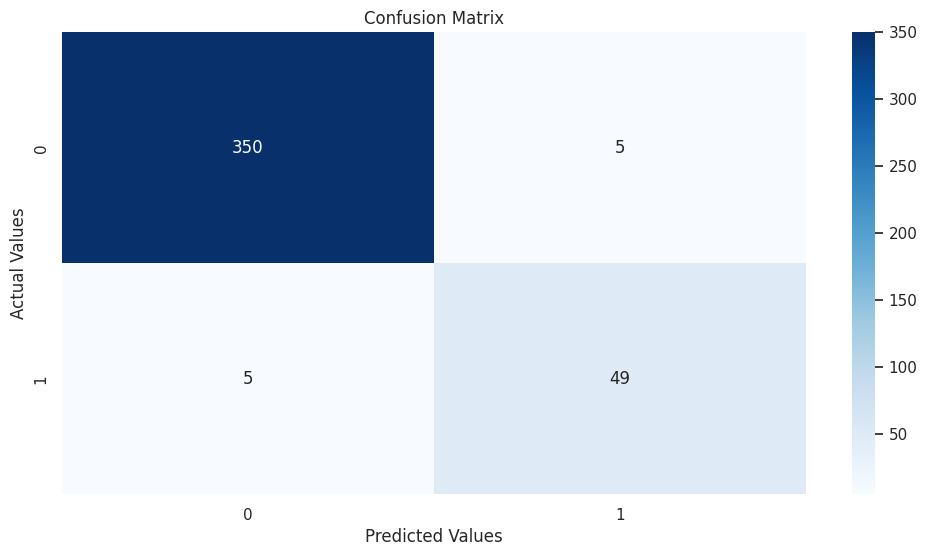

In [ ]:
#Побудуємо матрицю помилок (Confusion matrix)
cm_stack_clf=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,6))
plt.title('Confusion Matrix')
sns.heatmap(cm_stack_clf, annot=True,fmt='d', cmap='Blues')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

Підсумок вибору моделі: найкращою моделлю для датасету виявилась Random Forest з параметрами criterion = 'entropy', max_features = None, n_estimators = 30, яка дала такі оцінки:

Accuracy = 0.9829

Precision: 0.9273

Recall: 0.9444

F1: 0.9358
            
Хоча  XGBoost та Stacking з комбінацією RF, SVM , KNN + final LogRegression теж показали високі результати в оцінці цього датасету